## Implementation and simulation of EKF-SLAM algorithm

**PROJETO FINAL**

**Franci Rrapi (UFMG - 2021/1)**

## IMPLEMENTATION and TESTS

Below is the implementation and the simulation of this algorithm, you can find also the image tests made (they are also saved and available in the same folder of the notebook)

In this simulation of EKF SLAM, the meaning of the shown items are: 

- Black stars: landmarks
- Green crosses: estimates of landmark positions
- Blue line: ground truth position
- Red line: EKF SLAM position estimation

The EKF-SLAM algorithm consists of two main processes. At each time step, the following is done: 
- predict the new state using the control functions
- update the belief in landmark positions based on the estimated state and measurements
- add new landmark to the state

In [1]:
try:
    import sim
except:
    print ('--------------------------------------------------------------')
    print ('"sim.py" could not be imported. This means very probably that')
    print ('either "sim.py" or the remoteApi library could not be found.')
    print ('Make sure both are in the same folder as this file,')
    print ('or appropriately adjust the file "sim.py"')
    print ('--------------------------------------------------------------')
    print ('')

import time

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [3]:
#this function implements the kalman prediction step of our SLAM system
# inputs:
#   transition: is a data structure containing several things,
#               coming from the simulator
#               of these we are interested only in the offset
#               accessible through the "v" field of the structure
#
#               transition.v(1)=offset x
#               transition.v(2)=offset y (ignore for a diff drive robot)
#               transition.v(3)=offset theta
#
#  considering as 'm' the number of seen landmarks
#  mu: is the mean of (x,y,theta, l1, l2, ..., lm), i.e. the previously estimated robot pose
#      and the m landmark positions
#  sigma: is the covariance of the previously estimated robot pose and landmark positions ((3+m)x(3+m) matrix)

# outputs
# [mu, sigma] are mean and covariance of the estimate after transition

def prediction(mu, sigma, control_input):
    
    #domain spaces
    dimension_mu = mu.shape[0]
    dimension_u  = 2
    
    #readability: current pose
    mu_x     = mu[0]
    mu_y     = mu[1]
    mu_theta = mu[2]
    
    #readability: current control input
    u_x     = control_input[0] #translational velocity
    u_theta = control_input[1] #rotational velocity
    
    #Jacobian A
    #initialize A as an identity and fill only the robot block
    A = np.eye(dimension_mu, dimension_mu)
    A[0:3,0:3] = [[1, 0, -u_x*math.sin(mu_theta)],
                  [0, 1, u_x*math.cos(mu_theta)],
                  [0, 0, 1]]
    
    #Jacobian B
    #for each state variable we have to associate the available control inputs
    B = np.zeros((dimension_mu, dimension_u))
    B[0:3,:] = [[math.cos(mu_theta), 0],
                [math.sin(mu_theta), 0],
                [0,             1]]
      
    #predict the robot motion, this is our f(x,u) function in the slides
    #the transition model only affects the robot pose not the landmarks
    mu_r = transition_model(mu[0:3], control_input)
    #update the robot state
    mu[0:3] = mu_r
      
    #control noise u
    sigma_u = 0.1     #constant part
    sigma_T = u_x     #translational velocity dependent part
    sigma_R = u_theta #rotational velocity dependent part
      
    #compose control noise covariance sigma_u
    sigma_u = [[sigma_u**2+sigma_T**2, 0],
               [0, sigma_u**2+sigma_R**2]]
      
    #predict sigma
    sigma = A@sigma@A.T + B@sigma_u@B.T
      
    return mu, sigma

In [4]:
 """
 this function computes the transition of the robot after incorportating
 a movement u = [ux, uy, u_theta]
 in case of a differential drive robot, ignore uy (the case seen in the classroom)
 inputs:
   u(1): offset on x
   u(2): offset on y // ignore in case of differential drive
   u(3): offset on theta

   mu(1): x coord of robot w.r.t world
   mu(2): y coord of robot w.r.t world
   mu(3): angle of robot w.r.t world

 outputs:
   mu_prime(1): x coord of robot w.r.t world, after transition
   mu_prime(2): y coord of robot w.r.t world, after transition
   mu_prime(3): angle of robot w.r.t world, after transition
"""

def transition_model(mu, u):
    mu_prime = mu
    mu_x = mu[0]
    mu_y = mu[1] 
    mu_theta = mu[2]
    ux = u[0]
    utheta = u[1]
    c = math.cos(mu_theta)
    s = math.sin(mu_theta)

    mu_prime[0] = mu_x + ux*c
    mu_prime[1] = mu_y + ux*s
    mu_prime[2] = mu_theta + utheta

    return mu_prime

In [5]:
#this function computes the update (also called correction)
#step of the filter
#inputs:
#  mu: mean, 
#  sigma: covariance of the robot-landmark set (x,y, theta, l_1, ..., l_N)
#
#  observations:
#            a structure containing n observations of landmarks
#            for each observation we have
#            - the index of the landmark seen
#            - the location where we have seen the landmark (x,y) w.r.t the robot
#
#  id_to_state_map:
#            mapping that given the id of the measurement, returns its position in the mu vector
#  state_to_id_map:
#            mapping that given the index of mu vector, returns the id of the respective landmark
#
#outputs:
#  [mu, sigma]: the updated mean and covariance
#  [id_to_state_map, state_to_id_map]: the updated mapping vector between landmark position in mu vector and its id

def correction(mu, sigma, observations, id_to_state_map, state_to_id_map):
    
    #determine how many landmarks we have seen in this step
    M = len(observations)
    
#     if (M == 0):
#         return mu, sigma, id_to_state_map, state_to_id_map
    
    #dimension of the state (robot pose + landmark positions)
    dimension_state = mu.shape[0]
    mu_t            = mu[0:2] # translational part of the robot pose
    mu_theta        = mu[2] # rotation of the robot
    
    # re precompute some quantities that come in handy later on
    c   = math.cos(mu_theta)
    s   = math.sin(mu_theta)
    R   = np.array([[c, -s], [s, c]])  #rotation matrix
    Rt  = np.array([[c, s], [-s, c]])    #transposed rotation matrix
    Rtp = np.array([[-s, c], [-c,-s]]) #derivative of transposed rotation matrix
    
    # for below computation, we need to count how many observations 
    # of old landmarks we have
    number_of_known_landmarks = 0
    
    z_t = []
    h_t = []
    
    C_t = []
    
    # Here two cases arise, the current landmark has been already seen, i.e. REOBSERVED landmark,
    # or the current landmark is completely new, i.e. NEW landmark.
    #
    # for simplicity we can divide the problem: first analyze only the reobserved landmark
    # and work with them as in a localization procedure (of course, with full Jacobian now).
    # With this reobserved landmark we compute the correction/update of mean and covariance.
    # Then, after the correction is done, we can simply add the new landmark expanding the
    # mean and the covariance.
    #
    # First of all we are interested in REOBSERVED landmark 
    
    for i in range(M):
        
        #retrieve info about the observed landmark
        measurement = observations[i]
        
        #fetch the position in the state vector corresponding to the actual measurement
        n = int(id_to_state_map[measurement[2]])
#         print(n)
        
        #IF current landmark is a REOBSERVED LANDMARK
        if(n != -1):
            
            #compute the index (vector coordinate) in the state vector corresponding to the pose of the landmark;	
            id_state = 3+2*(n-1)
            
            #increment the counter of observations originating
            #from already known landmarks
            number_of_known_landmarks += 1
            
            #add landmark measurement
            x_pose = measurement[0]
            y_pose = measurement[1] 
#             print(x_pose)
            z_t.append([x_pose, y_pose])
            
            #fetch the position of the landmark in the state (its x and y coordinate)
            landmark_mu=mu[id_state:id_state+2]
            
            #where I predict i will see that landmark
            delta_t            = landmark_mu-mu_t
            measure_prediction = Rt @ delta_t######
            
            #add landmark measurement prediction
#             print(measure_prediction[0])
            h_t.append([measure_prediction[0], measure_prediction[1]])
            
            #jacobian piece w.r.t. robot
            C_m          = np.zeros((2, dimension_state))
#             print(C_m)
            C_m[0:2,0:2] = -Rt
#             print(Rt)
#             print(C_m)
#             print(Rtp @ delta_t)
            C_m[0:2,2]   = Rtp @ delta_t#######
#             print(C_m)
            
            #jacobian piece w.r.t. landmark
            C_m[:,id_state:id_state+2] = Rt
            
            #add jacobian piece to main jacobian
            C_t.append(C_m[0,:])
            C_t.append(C_m[1,:])

            
    C_t = np.asarray(C_t)
    z_t = np.asarray(z_t)
    h_t = np.asarray(h_t)
            
    if (number_of_known_landmarks > 0):

        #observation noise
        noise   = 0.01
        sigma_z = np.eye(2*number_of_known_landmarks)*noise
#         print(number_of_known_landmarks)
#         print(sigma)
#         print(sigma_z)
#         print(C_t.T)
#         print(sigma @ C_t.T)
#         print(C_t @ sigma @ C_t.T)
        #Kalman gain
        K = sigma @ C_t.T @ (np.linalg.inv(C_t @ sigma @ C_t.T + sigma_z))

        #update mu
#         print(z_t)
#         print(h_t)
        innovation = (z_t - h_t)
        innovation = innovation.reshape((number_of_known_landmarks*2, 1))
#         print(innovation)
#         print(mu)
#         print(K)
#         print(innovation)
#         print(K @ innovation.T)
#         print((K @ innovation).T[0])
#         print(np.append([],K @ innovation))
        
        mu         = mu + ((K @ innovation).T)[0]
        
#         print(mu)

        #update sigma
        sigma = (np.eye(dimension_state) - K@C_t)@sigma

        
    return mu, sigma, id_to_state_map, state_to_id_map

In [6]:
#this function adds new landmarks to the current state and current sigma
#inputs:
#  mu: mean, 
#  sigma: covariance of the robot-landmark set (x,y, theta, l_1, ..., l_N)
#
#  measurements:
#            a structure containing n measurements of landmarks
#            for each measurement we have
#            - the index of the landmark seen
#            - the location where we have seen the landmark (x,y) w.r.t the robot
#
#  id_to_state_map:
#            mapping that given the id of the measurement, returns its position in the mu vector
#  state_to_id_map:
#            mapping that given the index of mu vector, returns the id of the respective landmark
#
#outputs:
#  [mu, sigma]: the updated mean and covariance with new landmarks
#  [id_to_state_map, state_to_id_map]: the updated mapping vector between landmark position in mu vector and its id

def addNewLandmarks(mu, sigma, measurements, id_to_state_map, state_to_id_map):

    #robot
#     print(mu)
    mu_t     = mu[0:2]    #translational part of the robot pose
    mu_theta = mu[2]     #rotation of the robot
#     print(mu_theta)
    c        = math.cos(mu_theta)
    s        = math.sin(mu_theta)
    R        = np.array([[c, -s], [s, c]])

    #landmarks
    M = len(measurements) #number of measured landmarks
    n = (mu.shape[0]-3)//2                  #current number of landmarks in the state

    #Now its time to add, if observed, the NEW landmaks, without applying any correction
    for i in range(M):

        #retrieve info about the observed landmark
        measurement = measurements[i]

        #fetch the position in the state vector corresponding to the actual measurement
        state_pos_of_landmark = id_to_state_map[measurement[2]]

        #IF current landmark is a NEW landmark
        if (state_pos_of_landmark == -1): 

            #adjust direct and reverse id mappings
            n += 1
            id_to_state_map[measurement[2]] = n
            state_to_id_map[n]              = measurement[2]

            #compute landmark position in the world
            landmark_position_in_robot = np.array([measurement[0], measurement[1]])
            landmark_position_in_world = mu_t + R @ landmark_position_in_robot ###

            #retrieve from the index the position of the landmark block in the state
            id_state = 3+2*(n-1)

            #adding the landmark state to the full state
            mu = np.append(mu, landmark_position_in_world)

            #initial noise assigned to a new landmark
            #for simplicity we put a high value only in the diagonal.
            #A more deeper analysis on the initial noise should be made.
            initial_landmark_noise = 2
            sigma_landmark         = np.eye(2)*initial_landmark_noise
            
            len_sigma = len(sigma)
            sigma_ = np.zeros((len_sigma+2, len_sigma+2))
            sigma_[0:len_sigma, 0:len_sigma] = sigma
            

            #adding the landmark covariance to the full covariance
#             sigma[id_state,:]   = 0
#             sigma[id_state+1,:] = 0
#             sigma[:,id_state]   = 0
#             sigma[:,id_state+1] = 0

            #set the covariance block
#             sigma[id_state:id_state+1, id_state:id_state+1] = sigma_landmark
            sigma_[id_state:id_state+2, id_state:id_state+2] = sigma_landmark
    
            sigma = sigma_

            print("observed new landmark with ID: {}\n".format(measurement[2]))


    return mu, sigma, id_to_state_map, state_to_id_map


In [7]:
"""
This function simulates the observation of landmarks through a laser sensor. A landmark is
conseidered observed if the distance from robot to landmark is less or equal to the max sensor range.
"""

def get_observations(mu_r, landmarks, max_range):
    mu_x = mu_r[0]
    mu_y = mu_r[1] 
    mu_theta = mu_r[2]
    
    z = []
    for i in range(len(landmarks)):
        landmark_pose = landmarks[i]

        dx = landmark_pose[0] - mu_x
        dy = landmark_pose[1] - mu_y
        d = math.sqrt(dx**2 + dy**2)
        
        if d <= max_range:
            z.append([landmark_pose[0], landmark_pose[1], i+1])
            
    return z    

In [14]:
def main():
    print ('Program started')
    sim.simxFinish(-1) # just in case, close all opened connections
    clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

    if clientID!=-1:
        print ('Connected to remote API server')

        robotname = 'Pioneer_p3dx'
        returnCode, robotHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait) 
        returnCode, refHandle = sim.simxGetObjectHandle(clientID, "ReferenceFrame0", sim.simx_opmode_oneshot_wait)
        returnCode, goalHandle1 = sim.simxGetObjectHandle(clientID, "Goal1", sim.simx_opmode_oneshot_wait)
        returnCode, goalHandle2 = sim.simxGetObjectHandle(clientID, "Goal2", sim.simx_opmode_oneshot_wait)
        returnCode, goalHandle3 = sim.simxGetObjectHandle(clientID, "Goal3", sim.simx_opmode_oneshot_wait)
        returnCode, goalHandle4 = sim.simxGetObjectHandle(clientID, "Goal4", sim.simx_opmode_oneshot_wait)
        returnCode, goalHandle5 = sim.simxGetObjectHandle(clientID, "Goal5", sim.simx_opmode_oneshot_wait)
        returnCode, goalHandle6 = sim.simxGetObjectHandle(clientID, "Goal6", sim.simx_opmode_oneshot_wait)

        goal_handles = [goalHandle1, goalHandle2, goalHandle3, goalHandle4, goalHandle5, goalHandle6]


        returnCode, plantHandle1 = sim.simxGetObjectHandle(clientID, "indoorPlant1", sim.simx_opmode_oneshot_wait)
        returnCode, plantHandle2 = sim.simxGetObjectHandle(clientID, "indoorPlant2", sim.simx_opmode_oneshot_wait)
        returnCode, plantHandle3 = sim.simxGetObjectHandle(clientID, "indoorPlant3", sim.simx_opmode_oneshot_wait)
        returnCode, plantHandle4 = sim.simxGetObjectHandle(clientID, "indoorPlant4", sim.simx_opmode_oneshot_wait)
        returnCode, plantHandle5 = sim.simxGetObjectHandle(clientID, "indoorPlant5", sim.simx_opmode_oneshot_wait)

        plantPos = []
        returnCode, pos = sim.simxGetObjectPosition(clientID, plantHandle1, refHandle, sim.simx_opmode_oneshot_wait) 
        plantPos.append([pos[0], pos[1]])
        returnCode, pos = sim.simxGetObjectPosition(clientID, plantHandle2, refHandle, sim.simx_opmode_oneshot_wait) 
        plantPos.append([pos[0], pos[1]])
        returnCode, pos = sim.simxGetObjectPosition(clientID, plantHandle3, refHandle, sim.simx_opmode_oneshot_wait) 
        plantPos.append([pos[0], pos[1]])
        returnCode, pos = sim.simxGetObjectPosition(clientID, plantHandle4, refHandle, sim.simx_opmode_oneshot_wait) 
        plantPos.append([pos[0], pos[1]])
        returnCode, pos = sim.simxGetObjectPosition(clientID, plantHandle5, refHandle, sim.simx_opmode_oneshot_wait) 
        plantPos.append([pos[0], pos[1]])

        # Handle para as juntas das RODAS
        returnCode, l_wheel = sim.simxGetObjectHandle(clientID, robotname + '_leftMotor', sim.simx_opmode_oneshot_wait)
        returnCode, r_wheel = sim.simxGetObjectHandle(clientID, robotname + '_rightMotor', sim.simx_opmode_oneshot_wait)


        goals = []
        for goalHandle in goal_handles:
            returnCode, pos = sim.simxGetObjectPosition(clientID, goalHandle, refHandle, sim.simx_opmode_oneshot_wait)
            returnCode, ori = sim.simxGetObjectOrientation(clientID, goalHandle, refHandle, sim.simx_opmode_oneshot_wait)
    #         goal_angle = np.arctan2(pos[1]-qstart[1], pos[0] - qstart[0])
    #         qgoal = np.array([pos[0], pos[1], goal_angle])
            qgoal = np.array([pos[0], pos[1]])
            goals.append(qgoal)



        # Específico do robô
        # https://www.generationrobots.com/media/Pioneer3DX-P3DX-RevA.pdf
        L = 0.381
        r = 0.0975
        maxv = 1.0
        maxw = np.deg2rad(45)

        # RFID positions [x, y]
        plants = np.array([plantPos[0],
                              plantPos[1],
                              plantPos[2],
                              plantPos[3],
                              plantPos[4]])

        num_landmarks = len(plants)

        max_range = 7


        mu = [0,     # x coordinate
              0,     # y coordinate
              0]     # theta orientation 
        print("initial pose: [{}, {}, {}]\n".format(mu[0], mu[1], mu[2]))

        mu = np.asarray(mu)

        sigma = np.eye(3)

        id_to_state_map = np.ones(10000)*-1
        state_to_id_map = np.ones(10000)*-1

        trajectory = [[mu[0], mu[1]]]

        path = []

        for g in goals:
    #         print("1")

            returnCode, pos = sim.simxGetObjectPosition(clientID, robotHandle, refHandle, sim.simx_opmode_oneshot_wait)
            returnCode, ori = sim.simxGetObjectOrientation(clientID, robotHandle, refHandle, sim.simx_opmode_oneshot_wait)
            qstart = np.array([pos[0], pos[1], ori[2]])

            start = np.array([qstart[0], qstart[1]]) # Start location
            goal = np.array([g[0], g[1]]) # Goal location

            print("START: {}".format(start))
            print("GOAL: {}".format(goal))

            goal_angle = np.arctan2(goal[1]-qstart[1], goal[0] - qstart[0])
            qgoal = np.array([goal[0], goal[1], goal_angle])


            # Lembrar de habilitar o 'Real-time mode'
            startTime=time.time()
            lastTime = startTime

            limit = 100
            t = 0

            rho = np.inf
            while t < limit and rho > .5 :
    #                 print("3")

                now = time.time()
                dt = now - lastTime 

                returnCode, pos = sim.simxGetObjectPosition(clientID, robotHandle, refHandle, sim.simx_opmode_oneshot_wait)
                returnCode, ori = sim.simxGetObjectOrientation(clientID, robotHandle, refHandle, sim.simx_opmode_oneshot_wait)
                robotConfig = np.array([pos[0], pos[1], ori[2]])

                path.append(robotConfig[:2])

                dx, dy, dth = qgoal - robotConfig

                rho = np.sqrt(dx**2 + dy**2)


                kr = 1
                kt = 2

                v = kr*(dx*np.cos(robotConfig[2]) + dy*np.sin(robotConfig[2]))
                w = kt*(np.arctan2(dy,dx) - robotConfig[2])

                # Limit v,w to +/- max
                v = max(min(v, maxv), -maxv)
                w = max(min(w, maxw), -maxw) 

                wr = ((2.0*v) + (w*L))/(2.0*r)
                wl = ((2.0*v) - (w*L))/(2.0*r)

                # Enviando velocidades
                sim.simxSetJointTargetVelocity(clientID, r_wheel, wr, sim.simx_opmode_oneshot_wait)
                sim.simxSetJointTargetVelocity(clientID, l_wheel, wl, sim.simx_opmode_oneshot_wait)


                ############## HERE
                v_x = v*math.cos(robotConfig[2])
                transition = np.array([v_x, w])


                #EKF predict
                mu, sigma = prediction(mu, sigma, transition)

#                 returnCode, pos = sim.simxGetObjectPosition(clientID, robotHandle, refHandle, sim.simx_opmode_oneshot_wait)
#                 returnCode, ori = sim.simxGetObjectOrientation(clientID, robotHandle, refHandle, sim.simx_opmode_oneshot_wait)
#                 robotConfig = np.array([pos[0], pos[1], ori[2]])


                observations_t = get_observations(robotConfig, plants, max_range)
                
                if len(observations_t) > 0:

                    #EKF correct
                    mu, sigma, id_to_state_map, state_to_id_map = correction(mu, sigma, observations_t, id_to_state_map, state_to_id_map)
                    
                    #ADD new landmarks to the state
                    mu, sigma, id_to_state_map, state_to_id_map = addNewLandmarks(mu, sigma, observations_t, id_to_state_map, state_to_id_map)
                    
                #display current state - transform data
                N = (mu.shape[0]-3)//2
                if N > 0:
                    landmarks = []
                    landmarks.append([mu[3], mu[4], state_to_id_map[0]])
                    for u in range(1,N):
                        landmarks.append([mu[3+2*u], mu[3+2*u+1], state_to_id_map[u]])

                    print("current pose: [{}, {}, {}], map size (landmarks): {}\n".format(mu[0], mu[1], mu[2], N))
                    trajectory.append([mu[0], mu[1]])
                    
                    #display current state - transform data
                    plt.cla()
                    plt.plot(plants[:, 0], plants[:, 1], "*k")
                    plt.plot(mu[0], mu[1], ".r")

                    # plot landmark
                    for i in range(len(landmarks)):
                        plt.plot(landmarks[i][0],
                                 landmarks[i][1], "xg")
                    # plot true path
                    x_true = [x[0] for x in path]
                    y_true = [x[1] for x in path]
                    plt.plot(x_true,
                             y_true, "-b")
                    # plot estimated path
                    x_est = [x[0] for x in trajectory]
                    y_est = [x[1] for x in trajectory]
                    plt.plot(x_est,
                             y_est, "-r")

                    plt.axis("equal")
                    plt.grid(True)
                    plt.pause(0.001)

                time.sleep(.1)


                t = t + dt  
                lastTime = now
        plt.savefig("f.png")
        
        path = np.asarray(path)
        trajectory = np.asarray(trajectory)
        
        #display current state - transform data
        
#         plt.cla()
#         plt.plot(plants[:, 0], plants[:, 1], "*k")
#         plt.plot(mu[0], mu[1], ".r")

#         # plot landmark
#         for i in range(len(landmarks)):
#             plt.plot(landmarks[i][0],
#                      landmarks[i][1], "xg")
#         # plot true path
#         x_true = [x[0] for x in path]
#         y_true = [x[1] for x in path]
#         plt.plot(x_true,
#                  y_true, "-b")
#         # plot estimated path
#         x_est = [x[0] for x in trajectory]
#         y_est = [x[1] for x in trajectory]
#         plt.plot(x_est,
#                  y_est, "-r")

#         plt.axis("equal")
#         plt.grid(True)
#         plt.pause(0.001)
        

        # Parando o robô    
        sim.simxSetJointTargetVelocity(clientID, r_wheel, 0, sim.simx_opmode_oneshot_wait)
        sim.simxSetJointTargetVelocity(clientID, l_wheel, 0, sim.simx_opmode_oneshot_wait)

        # Parando a simulação     
        sim.simxStopSimulation(clientID,sim.simx_opmode_blocking)         

        # Now close the connection to CoppeliaSim:
        sim.simxFinish(clientID)

    else:
        print ('Failed connecting to remote API server')

    print ('Program ended')

Program started
Connected to remote API server
initial pose: [0, 0, 0]

START: [5.20479059 2.52466965]
GOAL: [12.62500191  3.950001  ]
observed new landmark with ID: 1

observed new landmark with ID: 4

observed new landmark with ID: 5

current pose: [0.0, 0.0, 0.0], map size (landmarks): 3



<IPython.core.display.Javascript object>


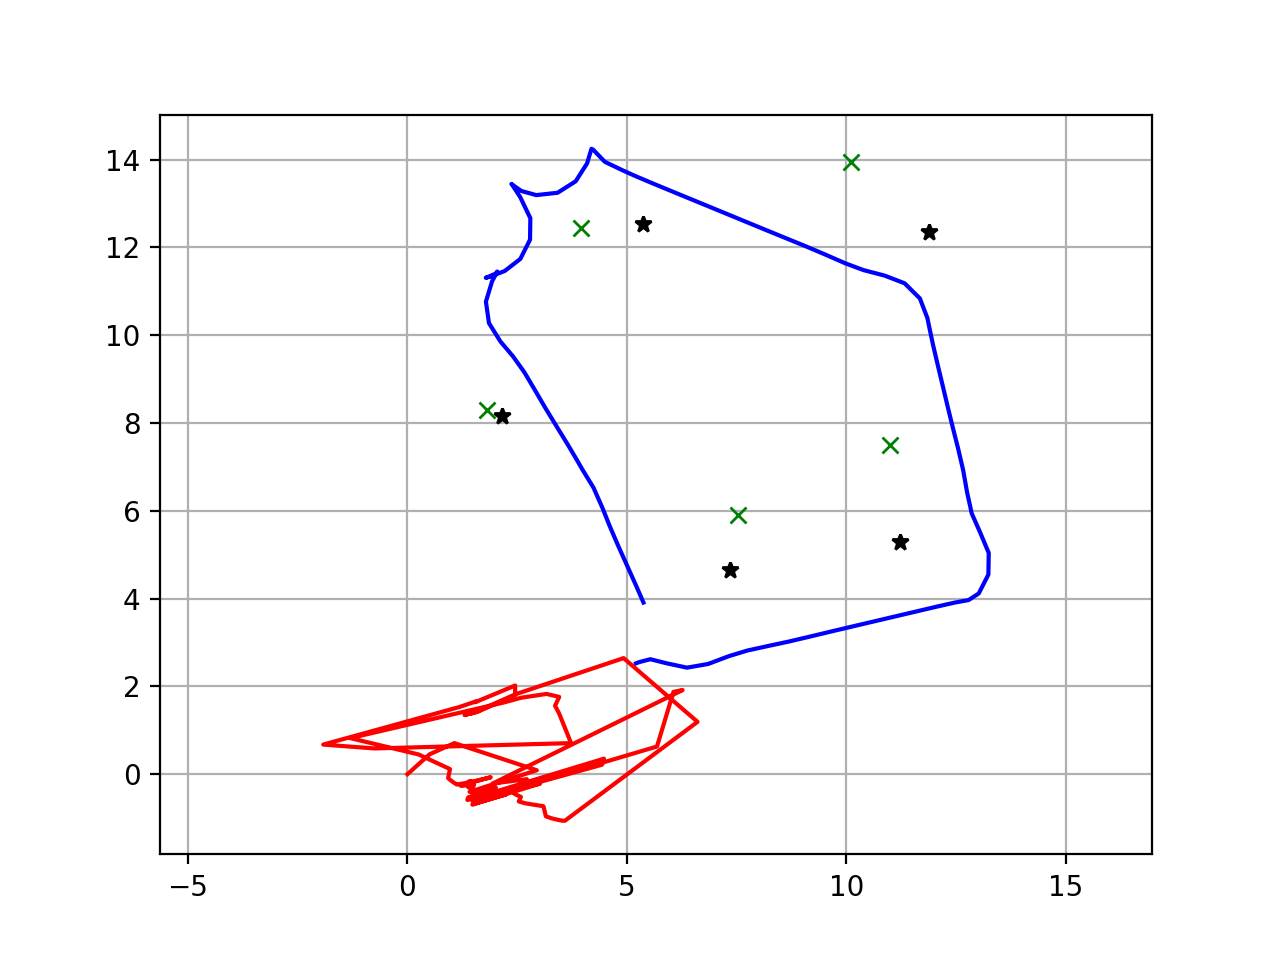

current pose: [0.5040055357735133, 0.4532973366104397, 0.012970013783917766], map size (landmarks): 3

current pose: [1.0688505581351344, 0.70868544159735, -0.07839589403184921], map size (landmarks): 3

current pose: [2.946864324613718, 0.09042141560974248, 0.23130723043795542], map size (landmarks): 3

current pose: [1.415000912786113, -0.4017759328272394, 0.1678578500235121], map size (landmarks): 3

current pose: [2.0145740071700655, -0.3052298917249484, 0.3293172641160996], map size (landmarks): 3

current pose: [1.6126320458479482, -0.448289037276868, 0.31190894646335215], map size (landmarks): 3

current pose: [1.3934284079041779, -0.5227399253126221, 0.27627834113854033], map size (landmarks): 3

current pose: [1.3827751968015582, -0.5324994614130811, 0.27462662642573343], map size (landmarks): 3

current pose: [1.3820428958898545, -0.5395489481791248, 0.27643840403811326], map size (landmarks): 3

current pose: [1.3834764485638962, -0.545859857625111, 0.2770841081971031], map 

current pose: [1.067655926501406, -0.1987598782393144, 0.17972884397728717], map size (landmarks): 5

current pose: [1.1044383907216673, -0.22044987163549232, 0.18381164648730758], map size (landmarks): 5

current pose: [1.1188967898731352, -0.2348638230552037, 0.18415827668826398], map size (landmarks): 5

START: [3.82809424 7.21483994]
GOAL: [5.55000019 3.52499962]
current pose: [1.3736314160903336, -0.19393663391447946, 0.21119153992055847], map size (landmarks): 5

current pose: [1.8972508449261296, -0.0696977323203766, 0.26021367864645184], map size (landmarks): 5

current pose: [1.2065595070548323, -0.2598428092567398, 0.19420622101583135], map size (landmarks): 5

current pose: [1.294578590821727, -0.2515182156767572, 0.2103625193889771], map size (landmarks): 5

current pose: [1.2915070538763402, -0.25862912825982776, 0.2102548760896989], map size (landmarks): 5

current pose: [1.418041451001972, -0.22804104076482623, 0.22787698325413136], map size (landmarks): 5

current pose:

In [15]:
%matplotlib notebook
%matplotlib notebook
main()